In [0]:
!pip install nengo

In [0]:
!pip install nengo_dl

In [0]:
%matplotlib inline

from urllib.request import urlretrieve

import nengo
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import nengo_dl

/usr/local/lib/python3.6/dist-packages/nengo_dl/converter.py:360: UserWarning: Layer '<class 'tensorflow.python.keras.layers.normalization_v2.BatchNormalization'>' already has a converter. Overwriting.
  "Layer '%s' already has a converter. Overwriting." % keras_layer


11493376/11490434 [==============================] - 0s 0us/step


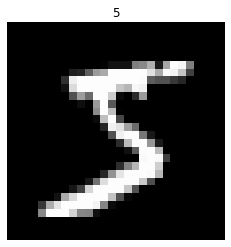

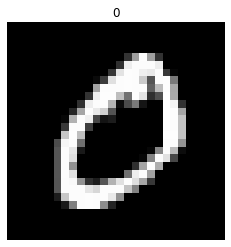

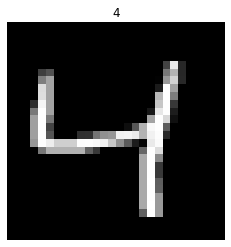

In [0]:
(train_images, train_labels), (test_images, test_labels) = (
    tf.keras.datasets.mnist.load_data())

# flatten images
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

for i in range(3):
    plt.figure()
    plt.imshow(np.reshape(train_images[i], (28, 28)),
               cmap="gray")
    plt.axis('off')
    plt.title(str(train_labels[i]));

In [0]:
with nengo.Network(seed=0) as net:
    net.config[nengo.Ensemble].max_rates = nengo.dists.Choice([100])
    net.config[nengo.Ensemble].intercepts = nengo.dists.Choice([0])
    net.config[nengo.Connection].synapse = None

    neuron_type = nengo.LIF(amplitude=0.01)

    nengo_dl.configure_settings(stateful=False)

    inp = nengo.Node(np.zeros(28 * 28))

    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=32, kernel_size=3))(inp, shape_in=(28, 28, 1))
    x = nengo_dl.Layer(neuron_type)(x)

    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=64, strides=2, kernel_size=3))(x, shape_in=(26, 26, 32))
    x = nengo_dl.Layer(neuron_type)(x)

    x = nengo_dl.Layer(tf.keras.layers.Conv2D(filters=128, strides=2, kernel_size=3))(x, shape_in=(12, 12, 64))
    x = nengo_dl.Layer(neuron_type)(x)

    out = nengo_dl.Layer(tf.keras.layers.Dense(units=10))(x)

    out_p = nengo.Probe(out, label="out_p")
    out_p_filt = nengo.Probe(out, synapse=0.1, label="out_p_filt")

In [0]:
minibatch_size = 200
sim = nengo_dl.Simulator(net, minibatch_size=minibatch_size)

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:07                                               


In [0]:
train_images = train_images[:, None, :]
train_labels = train_labels[:, None, None]

n_steps = 30
test_images = np.tile(test_images[:, None, :], (1, n_steps, 1))
test_labels = np.tile(test_labels[:, None, None], (1, n_steps, 1))

In [0]:
def classification_accuracy(y_true, y_pred):
    return tf.metrics.sparse_categorical_accuracy(y_true[:, -1], y_pred[:, -1])

sim.compile(loss={out_p_filt: classification_accuracy})

print("accuracy before training:", sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"])

accuracy before training: 0.09819999992847443


In [0]:
do_training = True
if do_training:
    sim.compile(optimizer=tf.optimizers.RMSprop(0.001), loss={out_p: tf.losses.SparseCategoricalCrossentropy(from_logits=True)})
    sim.fit(train_images, {out_p: train_labels}, epochs=10)

    sim.save_params("./mnist_params")
else:
    sim.load_params("./mnist_params")

Train on 60000 samples
Epoch 1/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.2633 - out_p_loss: 0.2633
Epoch 2/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0710 - out_p_loss: 0.0710
Epoch 3/10
60000/60000 [==============================] - 7s 113us/sample - loss: 0.0503 - out_p_loss: 0.0503
Epoch 4/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0384 - out_p_loss: 0.0384
Epoch 5/10
60000/60000 [==============================] - 7s 110us/sample - loss: 0.0305 - out_p_loss: 0.0305
Epoch 6/10
60000/60000 [==============================] - 7s 111us/sample - loss: 0.0257 - out_p_loss: 0.0257
Epoch 7/10
60000/60000 [==============================] - 7s 112us/sample - loss: 0.0197 - out_p_loss: 0.0197
Epoch 8/10
60000/60000 [==============================] - 7s 114us/sample - loss: 0.0169 - out_p_loss: 0.0169
Epoch 9/10
60000/60000 [==============================] - 7s 113us/sample - loss: 0.0130 - out_p_

In [0]:
sim.compile(loss={out_p_filt: classification_accuracy})
print("accuracy after training:", sim.evaluate(test_images, {out_p_filt: test_labels}, verbose=0)["loss"])

accuracy after training: 0.9880000078678131


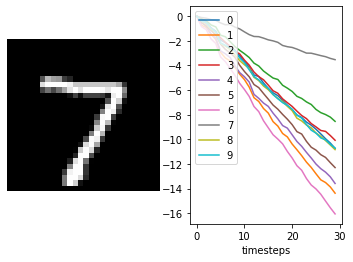

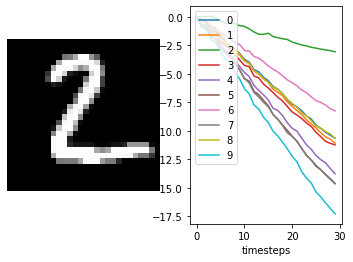

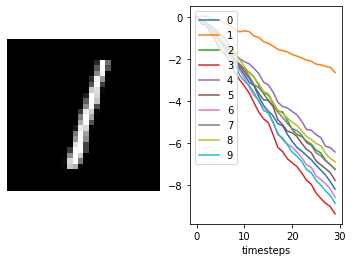

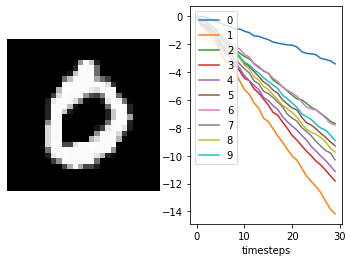

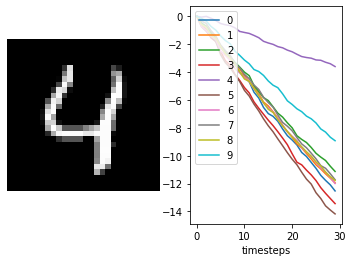

In [0]:
data = sim.predict(test_images[:minibatch_size])

for i in range(5):
    plt.figure()
    plt.subplot(1, 2, 1)
    plt.imshow(test_images[i, 0].reshape((28, 28)), cmap="gray")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.plot(data[out_p_filt][i])
    plt.legend([str(i) for i in range(10)], loc="upper left")
    plt.xlabel("timesteps")